### Load Forecasting

#### Monica Barros - v. 1.0 - 29/01/2017

In [1]:
print(R.Version()$version.string)

[1] "R version 3.3.2 (2016-10-31)"


In [2]:
# ==================================================================================
# Function Instala_Pacote
# ==================================================================================
# It works silently, echoing nothing if package "pacote" is already installed 
# and installing it otherwise. 
# Don't forget to write the name of the package between quotes!
# ==================================================================================
# Need to choose the CRAN mirror to avoid errors inside the Jupyter notebook
# ==================================================================================

instala_pacote <- function(pacote) {
  if (!pacote %in% installed.packages()) install.packages(pacote, repos = c("http://cloud.r-project.org/") )
}
# ==================================================================================


In [3]:
# Package Installation
instala_pacote("AzureML") # necessary only if using Azure Machine Learning (not local implementation)
instala_pacote("ggplot2")

Installing package into 'C:/Users/Monica/Documents/R/win-library/3.3'
(as 'lib' is unspecified)
also installing the dependencies 'XML', 'miniCRAN'



package 'XML' successfully unpacked and MD5 sums checked
package 'miniCRAN' successfully unpacked and MD5 sums checked
package 'AzureML' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Monica\AppData\Local\Temp\RtmpgZhHiL\downloaded_packages


In [4]:
instala_pacote("gbm")   # gradient boosting machine
instala_pacote("caret") # to estimate hyperparameters in GBM

Installing package into 'C:/Users/Monica/Documents/R/win-library/3.3'
(as 'lib' is unspecified)


package 'gbm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Monica\AppData\Local\Temp\RtmpgZhHiL\downloaded_packages


In [5]:
library("AzureML")
library("ggplot2")

In [ ]:
### Use this to sign in in Azure and download data
### ===============================================
### Code Snippet to read-in data set
### ===================================
ws <- workspace(
  id = "cee094f50cdd4a94b0e60771f06a0b3c",
  auth = "CjppaUQqoJdUBSp15XKz2Ma1hAQE1EytDAeBhaa0F8Ay+zSHwW6bqLYTQzw9+LGTabrUI7/sC9bsxu8MhHZRPA==",
  api_endpoint = "https://studioapi.azureml.net"
)

### Download data
dst <- download.datasets(dataset = ws,name = "PLD_ENA_Sudeste.csv")


In [61]:
### Use this to download local data
### ===========================================
dst = read.csv("PLD_ENA_Sudeste.csv", header = TRUE, sep = ";")

In [62]:
str(dst)

'data.frame':	796 obs. of  14 variables:
 $ Start.Date        : Factor w/ 796 levels "01/01/2002","01/01/2005",..: 1 108 290 472 654 33 215 397 579 6 ...
 $ End.Date          : Factor w/ 796 levels "01/01/2010","01/01/2016",..: 79 261 443 625 3 186 368 550 707 6 ...
 $ Date              : Factor w/ 795 levels "01/01/2010","01/01/2016",..: 79 261 443 625 3 186 368 550 6 6 ...
 $ SE_EAR_Average_MW : int  55636 62083 69841 75077 78741 83430 91800 99483 102088 105794 ...
 $ SE_EAR.           : num  34.5 37.1 41.7 44.8 47 ...
 $ ENA_Average_MW    : int  49893 40548 54053 84439 23894 64660 59647 54279 63196 45270 ...
 $ ENA._long_term_avg: num  126 76.5 102 159 44.7 ...
 $ Year              : int  2002 2002 2002 2002 2002 2002 2002 2002 2002 2002 ...
 $ Month             : int  1 1 1 1 2 2 2 2 3 3 ...
 $ Wk_of_Month       : int  1 2 3 4 1 2 3 4 1 1 ...
 $ Price_Heavy       : num  336 336 336 336 135 ...
 $ Price_Medium      : num  336 336 336 336 135 ...
 $ Price_Light       : num  336 336 3

In [63]:
tail(dst)

,Start.Date,End.Date,Date,SE_EAR_Average_MW,SE_EAR.,ENA_Average_MW,ENA._long_term_avg,Year,Month,Wk_of_Month,Price_Heavy,Price_Medium,Price_Light,Max_Price
791,21/01/2017,27/01/2017,27/01/2017,75441,36.8,54252,85,2017,1,4,131.27,131.27,127.50,533.82
792,28/01/2017,03/02/2017,03/02/2017,77491,37.8,55350,84,2017,2,1,101.31,101.31,99.46,533.82
793,04/02/2017,10/02/2017,10/02/2017,80976,39.5,53862,78,2017,2,2,112.71,112.71,110.50,533.82
794,11/02/2017,17/02/2017,17/02/2017,82411,40.2,52749,76,2017,2,3,122.27,122.27,118.69,533.82
795,18/02/2017,24/02/2017,24/02/2017,81591,39.8,43576,63,2017,2,4,133.87,133.87,129.74,533.82
796,25/02/2017,03/03/2017,03/03/2017,NA,NA,NA,NA,2017,3,1,186.18,185.54,183.00,533.82


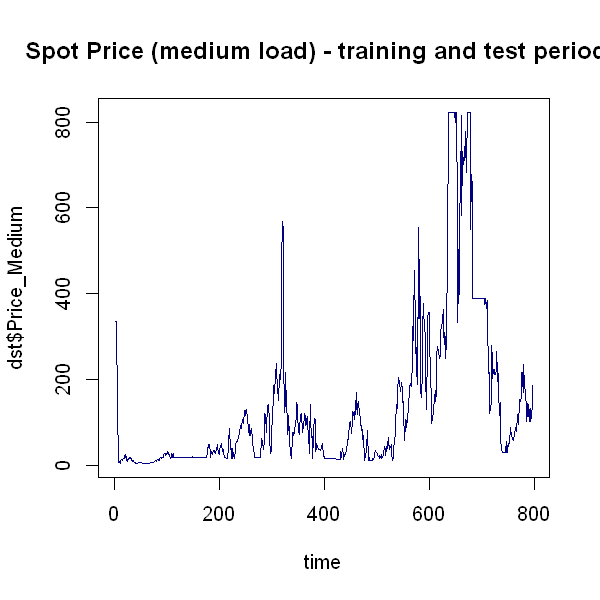

In [64]:
time=1:nrow(dst)
plot(time,dst$Price_Medium, type ="l", col = "navy", main = "Spot Price (medium load) - training and test periods")

In [65]:
typeof(dst$Price_Medium)

[1] "double"

In [66]:
# Package to resize plots
instala_pacote("repr")
library(repr)

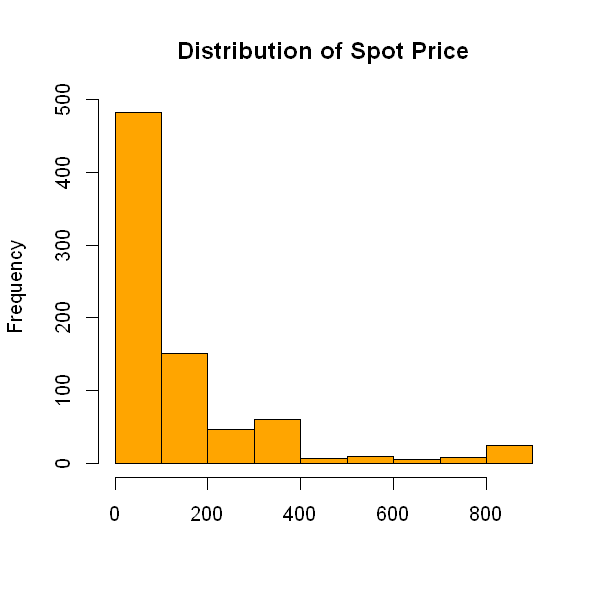

In [67]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(dst$Price_Medium, main = "Distribution of Spot Price", col = "orange", xlab = NULL)

### Script to create lagged variables

In [68]:
nlags = 8 # up to 8 weeks 
orig_names <- names(dst)
n_rows = nrow(dst) # or dim(dst)[1]
n_cols = ncol(dst) # or dim(dst)[2]

# computes lags of the Price_Heavy series (11th column of dataframe)
# ==================================================================
for (i in 1:nlags) {
       dst[1:i,n_cols+i] = 0 
       dst[(i+1):n_rows,n_cols+i] = dst[1:(n_rows-i),11]}  

# a ranges from 1 to nlags
a  =  1:nlags
new_names <- paste0("Price_Heavy_lag_",a)
names(dst) <- c(orig_names,new_names)

In [69]:
nlags = 8 # up to 8 weeks 
orig_names <- names(dst)
n_rows = nrow(dst) # or dim(dst)[1]
n_cols = ncol(dst) # or dim(dst)[2]

# computes lags of the Price_Medium series (12th column of dataframe)
# ==================================================================
for (i in 1:nlags) {
       dst[1:i,n_cols+i] = 0 
       dst[(i+1):n_rows,n_cols+i] = dst[1:(n_rows-i),12]}  

# a ranges from 1 to nlags
a  =  1:nlags
new_names <- paste0("Price_Medium_lag_",a)
names(dst) <- c(orig_names,new_names)

In [70]:
nlags = 8 # up to 8 weeks 
orig_names <- names(dst)
n_rows = nrow(dst) # or dim(dst)[1]
n_cols = ncol(dst) # or dim(dst)[2]

# computes lags of the Price_Light series (13th column of dataframe)
# ==================================================================
for (i in 1:nlags) {
       dst[1:i,n_cols+i] = 0 
       dst[(i+1):n_rows,n_cols+i] = dst[1:(n_rows-i),13]}  

# a ranges from 1 to nlags
a  =  1:nlags
new_names <- paste0("Price_Light_lag_",a)
names(dst) <- c(orig_names,new_names)

In [71]:
nlags = 8 # up to 8 weeks 
orig_names <- names(dst)
n_rows = nrow(dst) # or dim(dst)[1]
n_cols = ncol(dst) # or dim(dst)[2]

# computes lags of the SE_EAR_Average_MW series(4th column of dataframe)
# ==================================================================
for (i in 1:nlags) {
       dst[1:i,n_cols+i] = 0 
       dst[(i+1):n_rows,n_cols+i] = dst[1:(n_rows-i),4]}  

# a ranges from 1 to nlags
a  =  1:nlags
new_names <- paste0("SE_EAR_Average_MW_lag_",a)
names(dst) <- c(orig_names,new_names)

In [72]:
nlags = 8 # up to 8 weeks 
orig_names <- names(dst)
n_rows = nrow(dst) # or dim(dst)[1]
n_cols = ncol(dst) # or dim(dst)[2]

# computes lags of the ENA_Average_MW series (6th column of dataframe)
# ==================================================================
for (i in 1:nlags) {
       dst[1:i,n_cols+i] = 0 
       dst[(i+1):n_rows,n_cols+i] = dst[1:(n_rows-i),6]}  

# a ranges from 1 to nlags
a  =  1:nlags
new_names <- paste0("ENA_Average_MW_lag_",a)
names(dst) <- c(orig_names,new_names)

In [73]:
str(dst)

'data.frame':	796 obs. of  54 variables:
 $ Start.Date             : Factor w/ 796 levels "01/01/2002","01/01/2005",..: 1 108 290 472 654 33 215 397 579 6 ...
 $ End.Date               : Factor w/ 796 levels "01/01/2010","01/01/2016",..: 79 261 443 625 3 186 368 550 707 6 ...
 $ Date                   : Factor w/ 795 levels "01/01/2010","01/01/2016",..: 79 261 443 625 3 186 368 550 6 6 ...
 $ SE_EAR_Average_MW      : int  55636 62083 69841 75077 78741 83430 91800 99483 102088 105794 ...
 $ SE_EAR.                : num  34.5 37.1 41.7 44.8 47 ...
 $ ENA_Average_MW         : int  49893 40548 54053 84439 23894 64660 59647 54279 63196 45270 ...
 $ ENA._long_term_avg     : num  126 76.5 102 159 44.7 ...
 $ Year                   : int  2002 2002 2002 2002 2002 2002 2002 2002 2002 2002 ...
 $ Month                  : int  1 1 1 1 2 2 2 2 3 3 ...
 $ Wk_of_Month            : int  1 2 3 4 1 2 3 4 1 1 ...
 $ Price_Heavy            : num  336 336 336 336 135 ...
 $ Price_Medium           : num  3

### Specify factor variables

In [77]:
dst$Month = factor(dst$Month);
dst$Year =  factor(dst$Year);
dst$Wk_of_Month =  factor(dst$Wk_of_Month);

In [86]:
str(dst)

'data.frame':	796 obs. of  54 variables:
 $ Start.Date             : Factor w/ 796 levels "01/01/2002","01/01/2005",..: 1 108 290 472 654 33 215 397 579 6 ...
 $ End.Date               : Factor w/ 796 levels "01/01/2010","01/01/2016",..: 79 261 443 625 3 186 368 550 707 6 ...
 $ Date                   : Factor w/ 795 levels "01/01/2010","01/01/2016",..: 79 261 443 625 3 186 368 550 6 6 ...
 $ SE_EAR_Average_MW      : int  55636 62083 69841 75077 78741 83430 91800 99483 102088 105794 ...
 $ SE_EAR.                : num  34.5 37.1 41.7 44.8 47 ...
 $ ENA_Average_MW         : int  49893 40548 54053 84439 23894 64660 59647 54279 63196 45270 ...
 $ ENA._long_term_avg     : num  126 76.5 102 159 44.7 ...
 $ Year                   : Factor w/ 16 levels "2002","2003",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Month                  : Factor w/ 12 levels "1","2","3","4",..: 1 1 1 1 2 2 2 2 3 3 ...
 $ Wk_of_Month            : Factor w/ 5 levels "1","2","3","4",..: 1 2 3 4 1 2 3 4 1 1 ...
 $ Price_Heavy     

In [87]:
library(gbm)   # Gradient Boosting Machine
library(caret) # to estimate hyperparameters

### Splitting the data into training and testing

In [99]:
train_percentage = 75/100  # Define pecentage of data used in training

In [100]:
dst_train = dst[1:floor(train_percentage*nrow(dst)),] 

In [101]:
tail(dst_train)

,Start.Date,End.Date,Date,SE_EAR_Average_MW,SE_EAR.,ENA_Average_MW,ENA._long_term_avg,Year,Month,Wk_of_Month,...,SE_EAR_Average_MW_lag_7,SE_EAR_Average_MW_lag_8,ENA_Average_MW_lag_1,ENA_Average_MW_lag_2,ENA_Average_MW_lag_3,ENA_Average_MW_lag_4,ENA_Average_MW_lag_5,ENA_Average_MW_lag_6,ENA_Average_MW_lag_7,ENA_Average_MW_lag_8
592,06/04/2013,12/04/2013,12/04/2013,117740,58.5,56163,135,2013,4,2,...,89965,87550,54393,55587,51676,44928,42574,42763,53938,62422
593,13/04/2013,19/04/2013,19/04/2013,122973,61.1,59059,142,2013,4,3,...,91978,89965,56163,54393,55587,51676,44928,42574,42763,53938
594,20/04/2013,26/04/2013,26/04/2013,124986,62.1,43999,106,2013,4,4,...,94192,91978,59059,56163,54393,55587,51676,44928,42574,42763
595,27/04/2013,03/05/2013,03/05/2013,126193,62.7,33970,93,2013,5,1,...,97010,94192,43999,59059,56163,54393,55587,51676,44928,42574
596,04/05/2013,10/05/2013,10/05/2013,125992,62.6,29312,98,2013,5,2,...,101236,97010,33970,43999,59059,56163,54393,55587,51676,44928
597,11/05/2013,17/05/2013,17/05/2013,125187,62.2,27244,91,2013,5,3,...,107476,101236,29312,33970,43999,59059,56163,54393,55587,51676


In [102]:
dst_test=dst[(floor(0.75*nrow(dst))+1):n_rows,]

In [103]:
head(dst_test)

,Start.Date,End.Date,Date,SE_EAR_Average_MW,SE_EAR.,ENA_Average_MW,ENA._long_term_avg,Year,Month,Wk_of_Month,...,SE_EAR_Average_MW_lag_7,SE_EAR_Average_MW_lag_8,ENA_Average_MW_lag_1,ENA_Average_MW_lag_2,ENA_Average_MW_lag_3,ENA_Average_MW_lag_4,ENA_Average_MW_lag_5,ENA_Average_MW_lag_6,ENA_Average_MW_lag_7,ENA_Average_MW_lag_8
598,18/05/2013,24/05/2013,24/05/2013,124583,61.9,25981,87,2013,5,4,...,112105,107476,27244,29312,33970,43999,59059,56163,54393,55587
599,25/05/2013,31/05/2013,31/05/2013,126596,62.9,30506,102,2013,5,5,...,117740,112105,25981,27244,29312,33970,43999,59059,56163,54393
600,01/06/2013,07/06/2013,07/06/2013,128407,63.8,41279,163,2013,6,1,...,122973,117740,30506,25981,27244,29312,33970,43999,59059,56163
601,08/06/2013,14/06/2013,14/06/2013,128608,63.9,34114,135,2013,6,2,...,124986,122973,41279,30506,25981,27244,29312,33970,43999,59059
602,15/06/2013,21/06/2013,21/06/2013,127803,63.5,31093,123,2013,6,3,...,126193,124986,34114,41279,30506,25981,27244,29312,33970,43999
603,22/06/2013,28/06/2013,28/06/2013,128206,63.7,42634,168,2013,6,4,...,125992,126193,31093,34114,41279,30506,25981,27244,29312,33970


In [104]:
tail(dst_test)

,Start.Date,End.Date,Date,SE_EAR_Average_MW,SE_EAR.,ENA_Average_MW,ENA._long_term_avg,Year,Month,Wk_of_Month,...,SE_EAR_Average_MW_lag_7,SE_EAR_Average_MW_lag_8,ENA_Average_MW_lag_1,ENA_Average_MW_lag_2,ENA_Average_MW_lag_3,ENA_Average_MW_lag_4,ENA_Average_MW_lag_5,ENA_Average_MW_lag_6,ENA_Average_MW_lag_7,ENA_Average_MW_lag_8
791,21/01/2017,27/01/2017,27/01/2017,75441,36.8,54252,85,2017,1,4,...,67241,68266,44885,35392,32905,35617,42360,41114,31611,29386
792,28/01/2017,03/02/2017,03/02/2017,77491,37.8,55350,84,2017,2,1,...,69086,67241,54252,44885,35392,32905,35617,42360,41114,31611
793,04/02/2017,10/02/2017,10/02/2017,80976,39.5,53862,78,2017,2,2,...,70111,69086,55350,54252,44885,35392,32905,35617,42360,41114
794,11/02/2017,17/02/2017,17/02/2017,82411,40.2,52749,76,2017,2,3,...,69291,70111,53862,55350,54252,44885,35392,32905,35617,42360
795,18/02/2017,24/02/2017,24/02/2017,81591,39.8,43576,63,2017,2,4,...,67241,69291,52749,53862,55350,54252,44885,35392,32905,35617
796,25/02/2017,03/03/2017,03/03/2017,NA,NA,NA,NA,2017,3,1,...,67241,67241,43576,52749,53862,55350,54252,44885,35392,32905


In [106]:
str(dst_train)

'data.frame':	597 obs. of  54 variables:
 $ Start.Date             : Factor w/ 796 levels "01/01/2002","01/01/2005",..: 1 108 290 472 654 33 215 397 579 6 ...
 $ End.Date               : Factor w/ 796 levels "01/01/2010","01/01/2016",..: 79 261 443 625 3 186 368 550 707 6 ...
 $ Date                   : Factor w/ 795 levels "01/01/2010","01/01/2016",..: 79 261 443 625 3 186 368 550 6 6 ...
 $ SE_EAR_Average_MW      : int  55636 62083 69841 75077 78741 83430 91800 99483 102088 105794 ...
 $ SE_EAR.                : num  34.5 37.1 41.7 44.8 47 ...
 $ ENA_Average_MW         : int  49893 40548 54053 84439 23894 64660 59647 54279 63196 45270 ...
 $ ENA._long_term_avg     : num  126 76.5 102 159 44.7 ...
 $ Year                   : Factor w/ 16 levels "2002","2003",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Month                  : Factor w/ 12 levels "1","2","3","4",..: 1 1 1 1 2 2 2 2 3 3 ...
 $ Wk_of_Month            : Factor w/ 5 levels "1","2","3","4",..: 1 2 3 4 1 2 3 4 1 1 ...
 $ Price_Heavy     

In [143]:
cols_to_ignore <- -c(1, 2, 3, 4, 5, 6, 7, 11, 13, 14,15:22,30:38)
head(dst_train[,cols_to_ignore])  # This dataframe contains ONLY the columns we want to INCLUDE in the model

Year,Month,Wk_of_Month,Price_Medium,Price_Medium_lag_1,Price_Medium_lag_2,Price_Medium_lag_3,Price_Medium_lag_4,Price_Medium_lag_5,Price_Medium_lag_6,...,SE_EAR_Average_MW_lag_7,SE_EAR_Average_MW_lag_8,ENA_Average_MW_lag_1,ENA_Average_MW_lag_2,ENA_Average_MW_lag_3,ENA_Average_MW_lag_4,ENA_Average_MW_lag_5,ENA_Average_MW_lag_6,ENA_Average_MW_lag_7,ENA_Average_MW_lag_8
2002,1,1,336.00,0.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002,1,2,336.00,336.00,0,0,0,0,0,...,0,0,49893,0,0,0,0,0,0,0
2002,1,3,336.00,336.00,336,0,0,0,0,...,0,0,40548,49893,0,0,0,0,0,0
2002,1,4,336.00,336.00,336,336,0,0,0,...,0,0,54053,40548,49893,0,0,0,0,0
2002,2,1,134.76,336.00,336,336,336,0,0,...,0,0,84439,54053,40548,49893,0,0,0,0
2002,2,2,134.76,134.76,336,336,336,336,0,...,0,0,23894,84439,54053,40548,49893,0,0,0


### Create smaller dataframes with only variables to be included in GBM

In [145]:
dst_train_small = dst_train[,cols_to_ignore]

In [146]:
dst_test_small = dst_test[, cols_to_ignore]

In [147]:
str(dst_train_small)

'data.frame':	597 obs. of  27 variables:
 $ Year                   : Factor w/ 16 levels "2002","2003",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Month                  : Factor w/ 12 levels "1","2","3","4",..: 1 1 1 1 2 2 2 2 3 3 ...
 $ Wk_of_Month            : Factor w/ 5 levels "1","2","3","4",..: 1 2 3 4 1 2 3 4 1 1 ...
 $ Price_Medium           : num  336 336 336 336 135 ...
 $ Price_Medium_lag_1     : num  0 336 336 336 336 ...
 $ Price_Medium_lag_2     : num  0 0 336 336 336 ...
 $ Price_Medium_lag_3     : num  0 0 0 336 336 ...
 $ Price_Medium_lag_4     : num  0 0 0 0 336 ...
 $ Price_Medium_lag_5     : num  0 0 0 0 0 ...
 $ Price_Medium_lag_6     : num  0 0 0 0 0 0 336 336 336 336 ...
 $ Price_Medium_lag_7     : num  0 0 0 0 0 0 0 336 336 336 ...
 $ SE_EAR_Average_MW_lag_1: num  0 55636 62083 69841 75077 ...
 $ SE_EAR_Average_MW_lag_2: num  0 0 55636 62083 69841 ...
 $ SE_EAR_Average_MW_lag_3: num  0 0 0 55636 62083 ...
 $ SE_EAR_Average_MW_lag_4: num  0 0 0 0 55636 ...
 $ SE_EAR_Average_

In [149]:
str(dst_test_small)

'data.frame':	199 obs. of  27 variables:
 $ Year                   : Factor w/ 16 levels "2002","2003",..: 12 12 12 12 12 12 12 12 12 12 ...
 $ Month                  : Factor w/ 12 levels "1","2","3","4",..: 5 5 6 6 6 6 7 7 7 7 ...
 $ Wk_of_Month            : Factor w/ 5 levels "1","2","3","4",..: 4 5 1 2 3 4 1 2 3 4 ...
 $ Price_Medium           : num  357 357 325 181 194 ...
 $ Price_Medium_lag_1     : num  357 357 357 325 181 ...
 $ Price_Medium_lag_2     : num  342 357 357 357 325 ...
 $ Price_Medium_lag_3     : num  279 342 357 357 357 ...
 $ Price_Medium_lag_4     : num  129 279 342 357 357 ...
 $ Price_Medium_lag_5     : num  151 129 279 342 357 ...
 $ Price_Medium_lag_6     : num  191 151 129 279 342 ...
 $ Price_Medium_lag_7     : num  300 191 151 129 279 ...
 $ SE_EAR_Average_MW_lag_1: num  125187 124583 126596 128407 128608 ...
 $ SE_EAR_Average_MW_lag_2: num  125992 125187 124583 126596 128407 ...
 $ SE_EAR_Average_MW_lag_3: num  126193 125992 125187 124583 126596 ...
 $ S

### Forecasting using GBM

In [150]:
model_struc = as.formula("dst_train_small$Price_Medium ~ .")

In [51]:
### EXplicity declare the model formula


### model_struc = as.formula("dst_train$Demand ~ .  - dst_train$Month - dst_train$Day - dst_train$July - dst_train$winter - dst_train$fall - dst_train$summer - dst_train$spring")

# model_struc = as.formula("dst_train$Demand ~ dst_train$Year +  dst_train$Hour +  dst_train$Day_of_week +  dst_train$DaylightSavingsTime  +  dst_train$Temp +    dst_train$Temp_lag_1     +     dst_train$Temp_lag_2    +      dst_train$Temp_lag_3    +      dst_train$Temp_lag_4     +     dst_train$Temp_lag_5      +    dst_train$Temp_lag_6 +   dst_train$Temp_lag_12 +  dst_train$Temp_lag_24  +  dst_train$Temp_lag_25  +  dst_train$Temp_lag_168 +  dst_train$Temp_lag_169 +  dst_train$January +  dst_train$February +  dst_train$March +  dst_train$April +  dst_train$May +  dst_train$June +  dst_train$July +  dst_train$August +  dst_train$September +  dst_train$October +  dst_train$November +  dst_train$December +  dst_train$Demand_lag_1       +  dst_train$Demand_lag_2       +  dst_train$Demand_lag_3       +  dst_train$Demand_lag_4       +  dst_train$Demand_lag_5       +  dst_train$Demand_lag_6       +  dst_train$Demand_lag_7       +  dst_train$Demand_lag_8       +  dst_train$Demand_lag_9       +  dst_train$Demand_lag_10      +  dst_train$Demand_lag_11      +  dst_train$Demand_lag_12      +  dst_train$Demand_lag_13      +  dst_train$Demand_lag_14      +  dst_train$Demand_lag_15      +  dst_train$Demand_lag_16      +  dst_train$Demand_lag_17      +  dst_train$Demand_lag_18      +  dst_train$Demand_lag_19      +  dst_train$Demand_lag_20      +  dst_train$Demand_lag_21      +  dst_train$Demand_lag_22      +  dst_train$Demand_lag_23      +  dst_train$Demand_lag_24")  
# model_struc = as.formula(paste0("dst_train$Demand ~ ", paste0("dst_train$",paste(colnames(dst_train[,cols_to_ignore])), collapse = " + ")))

In [122]:
# model_struc = as.formula("dst$Price_Medium ~ dst$Year + dst$Month + dst$Wk_of_Month + dst$Price_Medium_lag_1 + 
#+dst$Price_Medium_lag_2 + dst$Price_Medium_lag_3 + dst$Price_Medium_lag_4 + dst$Price_Medium_lag_5 +
#+dst$Price_Medium_lag_6 + dst$Price_Medium_lag_7 +
#+dst$Price_Medium_lag_8 + dst$SE_EAR_Average_MW_lag_1 +
#+dst$SE_EAR_Average_MW_lag_2 + dst$SE_EAR_Average_MW_lag_3 + dst$SE_EAR_Average_MW_lag_4 +
# + dst$SE_EAR_Average_MW_lag_5 + dst$SE_EAR_Average_MW_lag_6 + dst$SE_EAR_Average_MW_lag_7 +
# + dst$SE_EAR_Average_MW_lag_8 + dst$ENA_Average_MW_lag_1 + dst$ENA_Average_MW_lag_2 +
# + dst$ENA_Average_MW_lag_3 + dst$ENA_Average_MW_lag_4   + dst$ENA_Average_MW_lag_5 +
# + dst$ENA_Average_MW_lag_6  + dst$ENA_Average_MW_lag_7  + dst$ENA_Average_MW_lag_8")   


In [151]:
model_struc

dst_train_small$Price_Medium ~ .

In [139]:
#model_struc = as.formula("dst$Price_Medium ~ . - dst$Start.Date - dst$End.Date - dst$Date - dst$SE_EAR_Average_MW -dst$SE_EAR. -
#- dst$ENA_Average_MW - dst$ENA._long_term_avg - dst$Price_Heavy - dst$Price_Light - dst$Max_Price - dst$Price_Heavy_lag_1 -
#- dst$Price_Heavy_lag_2 - dst$Price_Heavy_lag_3 - dst$Price_Heavy_lag_4 - dst$Price_Heavy_lag_5 - dst$Price_Heavy_lag_6 -
#- dst$Price_Heavy_lag_7 - dst$Price_Heavy_lag_8 - dst$Price_Light_lag_1 - dst$Price_Light_lag_2 - dst$Price_Light_lag_3 -
#- dst$Price_Light_lag_4 - dst$Price_Light_lag_5 - dst$Price_Light_lag_6 - dst$Price_Light_lag_7 - dst$Price_Light_lag_8")

In [152]:
model_struc

dst_train_small$Price_Medium ~ .

#### TEM UM TREMENDO BUG NA ESPECIFICACAO DISSO. O gmb NAO RECONHECE AS VARIAVEIS QUE ESTOU EXCLUINDO E AJUSTA O MODELO COM TUDO.
 SE EU MUDO A ESPECIFICACAO PARA INCLUIR APENAS AS VARIAVIES DE INTERESSE, A RODADA FUNCIONA, MAS DÁ ERRO QUANDO QUERO FAZER 
 A PREVISAO, O R RECLAMA DOS COMPRIMENTOS DIFERENTES DAS SERIES NO IN E OUT OF SAMPLE.

In [153]:
# Computing GBM model and keeping track of time taken to run
#
# tic and toc are an "inspiration" from Matlab

## dst_train$Demand ~ .  - dst_train$Month - dst_train$Day - dst_train$July - dst_train$winter - dst_train$fall - dst_train$summer - dst_train$spring, 
           
tic = Sys.time()

set.seed(123) # To make sure results can be repeated
# Note that we are excluding the dummies for the seasons and July (all other monthly dummies kept)
gbm1 <- gbm(formula = model_struc, distribution = "gaussian",
            n.trees =  1000, # c(5000, 7500, 10000)
            interaction.depth = 3,
            n.minobsinnode = 2, #c(1,2)
            shrinkage = 0.01,
            cv.folds = 2,
            data = dst_train_small, keep.data = FALSE,
            n.cores = NULL) # You can set this to n.cores = NULL to use all cores
best.iter <- gbm.perf(gbm1, method="cv", plot=FALSE)

toc = Sys.time()

delta_t = toc - tic  # Computes elapsed time

In [154]:
print(paste0("Elapsed Time to run GBM: " , round(delta_t,2)))

[1] "Elapsed Time to run GBM: 10.57"


In [155]:
# print model
print(gbm1) 

gbm(formula = model_struc, distribution = "gaussian", data = dst_train_small, 
    n.trees = 1000, interaction.depth = 3, n.minobsinnode = 2, 
    shrinkage = 0.01, cv.folds = 2, keep.data = FALSE, n.cores = NULL)
A gradient boosted model with gaussian loss function.
1000 iterations were performed.
The best cross-validation iteration was 415.
There were 26 predictors of which 26 had non-zero influence.


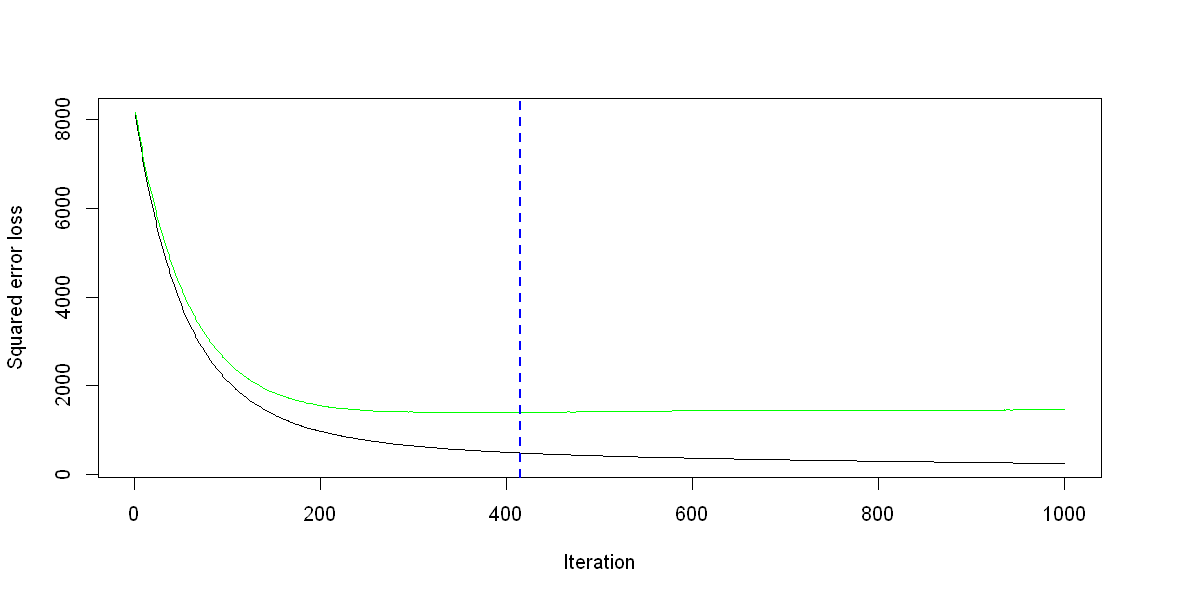

In [156]:
# check performance using 5-fold cross-validation
options(repr.plot.width = 10, repr.plot.height = 5)
best.iter <- gbm.perf(gbm1,method="cv")

,var,rel.inf
Price_Medium_lag_1,Price_Medium_lag_1,73.49767280
Price_Medium_lag_2,Price_Medium_lag_2,4.17572469
Month,Month,3.06951421
SE_EAR_Average_MW_lag_1,SE_EAR_Average_MW_lag_1,2.50152934
Price_Medium_lag_3,Price_Medium_lag_3,2.21671340
Year,Year,1.72491909
Price_Medium_lag_5,Price_Medium_lag_5,1.64603996
Price_Medium_lag_4,Price_Medium_lag_4,1.61820868
ENA_Average_MW_lag_2,ENA_Average_MW_lag_2,1.09783552
Price_Medium_lag_7,Price_Medium_lag_7,1.09080250


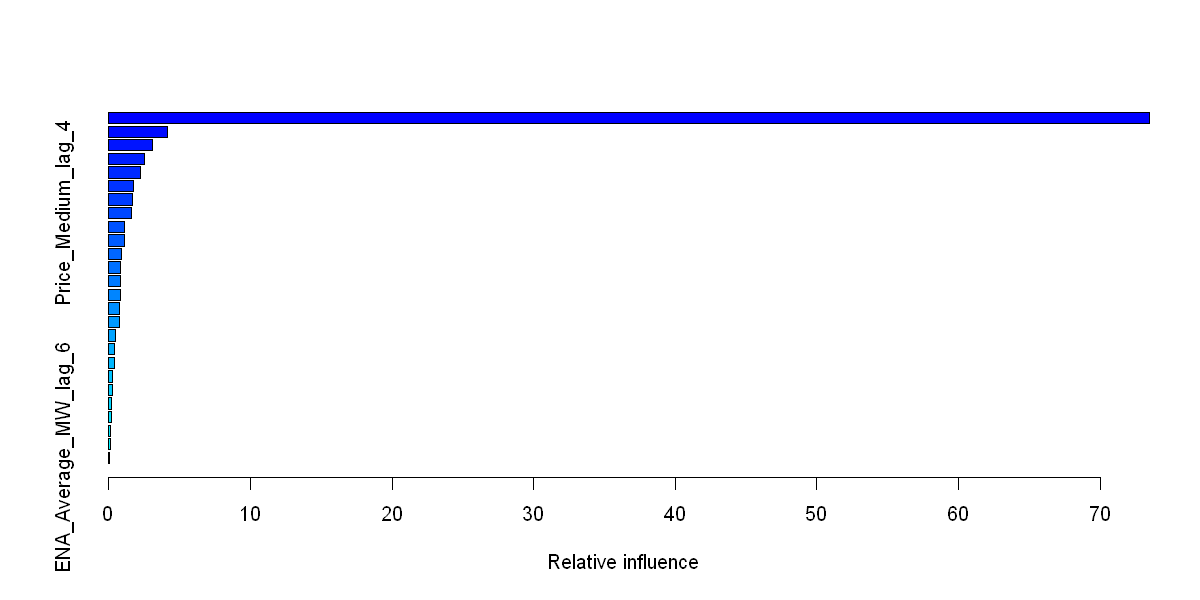

In [157]:
# summary - Gradient Boosting Machine - variables in descending order of importance
summary(gbm1)

#### A plot comparing the importance of variables is generated with the following code.

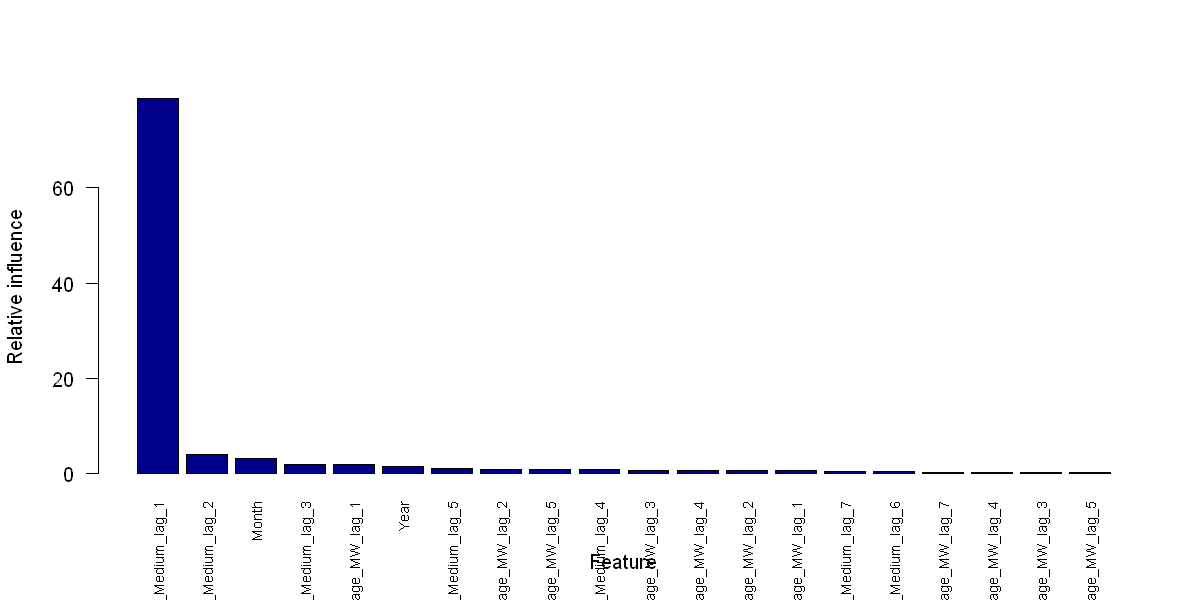

In [160]:
options(repr.plot.width = 10, repr.plot.height = 5)
# check variable importance
f_imp <- summary(gbm1, n.trees = best.iter, plot = FALSE) 
# use a custom plot to show variable importance

# Show first 20 variables only
barplot(f_imp$rel.inf[1:20], names.arg = f_imp$var[1:20], xlab = "Feature", ylab = "Relative influence", las = 2, cex.names = 0.7, col=c("darkblue"))

In [161]:
# Top 20 variables and their relative importances
head(f_imp,20)

,var,rel.inf
Price_Medium_lag_1,Price_Medium_lag_1,78.7346809
Price_Medium_lag_2,Price_Medium_lag_2,4.1314511
Month,Month,3.1286224
Price_Medium_lag_3,Price_Medium_lag_3,1.8633877
SE_EAR_Average_MW_lag_1,SE_EAR_Average_MW_lag_1,1.8568719
Year,Year,1.4816408
Price_Medium_lag_5,Price_Medium_lag_5,1.0293421
ENA_Average_MW_lag_2,ENA_Average_MW_lag_2,0.8779375
SE_EAR_Average_MW_lag_5,SE_EAR_Average_MW_lag_5,0.8690493
Price_Medium_lag_4,Price_Medium_lag_4,0.8539392


In [162]:
# Define prediction function
predict_gbm <- function(newdata)
{
  require(gbm)
  predict(gbm1, newdata, best.iter)
}

In [167]:
# test the prediction function
newdata <- dst_test_small
pred <- predict_gbm(dst_test_small)
actual = dst_test_small$Price_Medium

In [168]:
str(pred)

 num [1:199] 366 358 335 271 174 ...


In [169]:
perc_error = round(100*((actual-pred)/actual), digits = 3)
abs_perc_error = abs(perc_error)
result_test_period = data.frame(actual, forecast = pred, perc_error, abs_perc_error);

In [170]:
MAPE = function(real, pred){
    y = 100 * mean(abs((real-pred)/real), na.rm = TRUE)
    return(y)
    }

In [171]:
print(paste0("MAPE = ", round(MAPE(actual,pred),4)))

[1] "MAPE = 24.7256"


In [174]:
head(result_test_period)

actual,forecast,perc_error,abs_perc_error
356.80,365.6184,-2.472,2.472
357.29,357.5283,-0.067,0.067
324.69,335.3679,-3.289,3.289
180.95,271.3855,-49.978,49.978
193.93,174.0999,10.225,10.225
167.90,199.8492,-19.029,19.029


In [175]:
tail(result_test_period)

,actual,forecast,perc_error,abs_perc_error
194,131.27,146.48143,-11.588,11.588
195,101.31,127.56113,-25.912,25.912
196,112.71,92.45471,17.971,17.971
197,122.27,91.05051,25.533,25.533
198,133.87,106.20898,20.663,20.663
199,185.54,125.94121,32.122,32.122


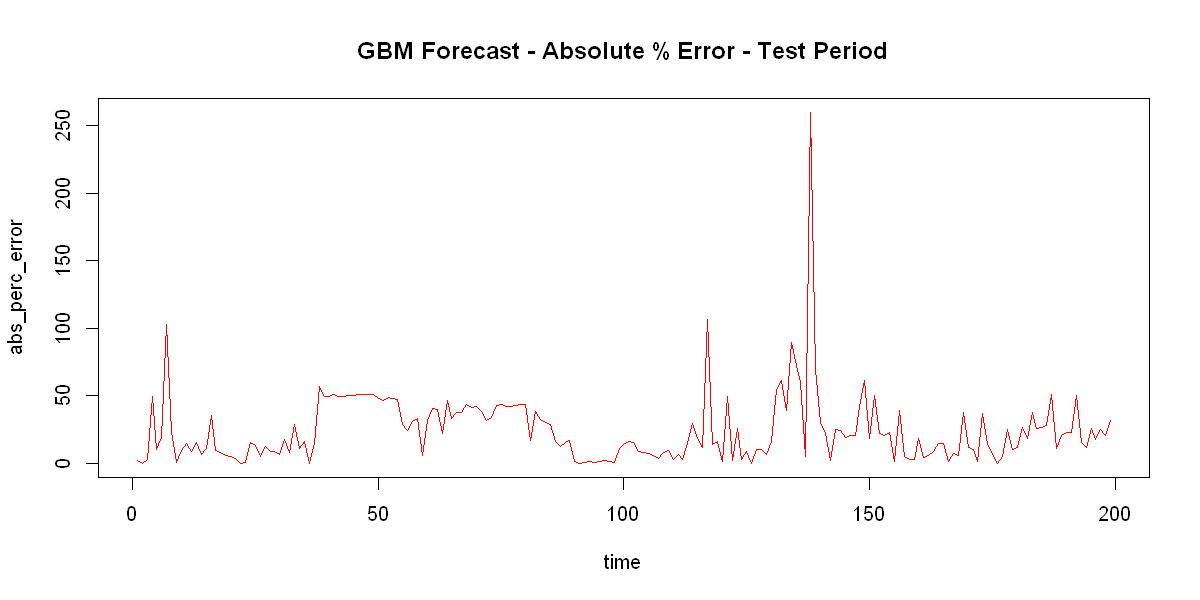

In [177]:
time=1:nrow(result_test_period)
plot(time,abs_perc_error, type ="l", col = "red", main = "GBM Forecast - Absolute % Error - Test Period")

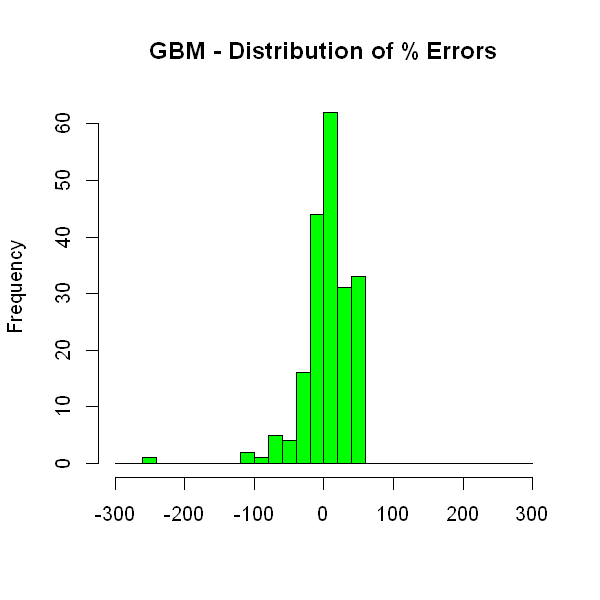

In [183]:
# Histogram of Absolute Percentage Errors 
options(repr.plot.width = 5, repr.plot.height = 5)
hist(perc_error, main = "GBM - Distribution of % Errors", col = "green", xlab = NULL, breaks = seq(-300,300,20))

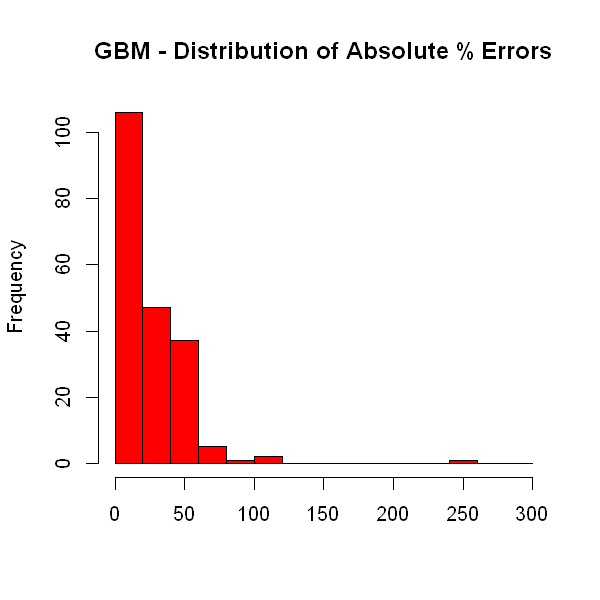

In [182]:
# Histogram of Absolute Percentage Errors 
options(repr.plot.width = 5, repr.plot.height = 5)
hist(abs_perc_error, main = "GBM - Distribution of Absolute % Errors", col = "red", xlab = NULL, breaks = seq(0,300,20))

In [184]:
MAPE = mean(abs_perc_error)
print(paste0("MAPE = ", round(MAPE,4)))

[1] "MAPE = 24.7256"


In [187]:
print(paste0("Minimum % Error (test period): ", min(perc_error, na.rm = TRUE)))

[1] "Minimum % Error (test period): -259.602"


In [188]:
print(paste0("Maximum  % Error (test period): ",max(perc_error, na.rm = TRUE)))

[1] "Maximum  % Error (test period): 57.244"


In [189]:
head(result_test_period)

actual,forecast,perc_error,abs_perc_error
356.80,365.6184,-2.472,2.472
357.29,357.5283,-0.067,0.067
324.69,335.3679,-3.289,3.289
180.95,271.3855,-49.978,49.978
193.93,174.0999,10.225,10.225
167.90,199.8492,-19.029,19.029


In [190]:
summary(perc_error)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-259.600   -8.702    7.213    5.656   29.540   57.240 

`geom_smooth()` using method = 'loess'


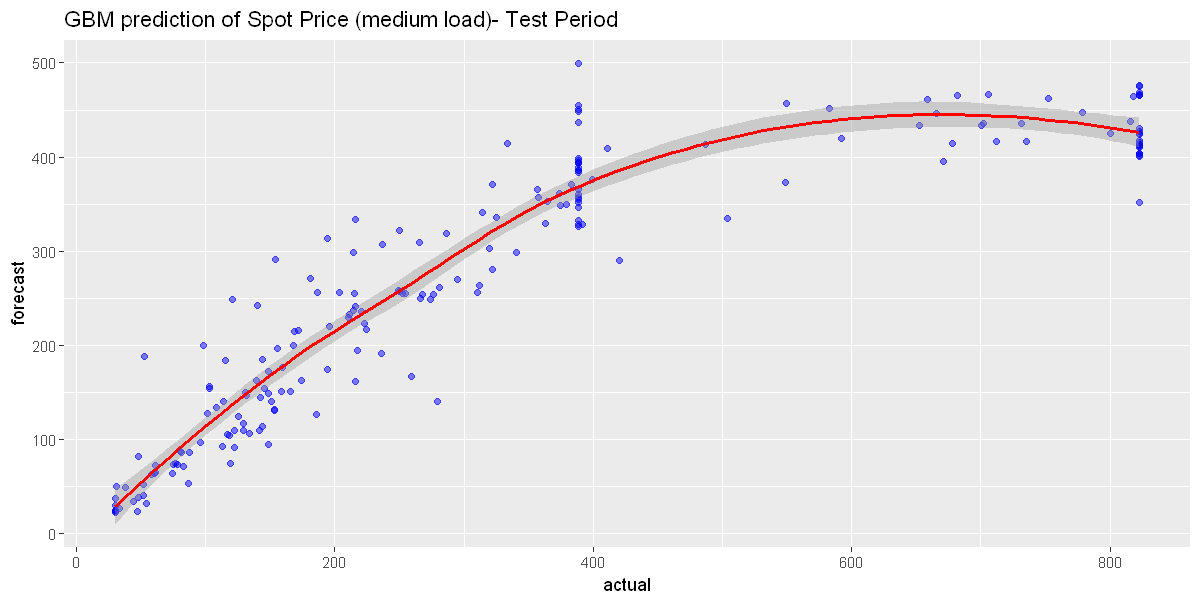

In [191]:
library(ggplot2)
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(result_test_period, aes(x = actual, y = forecast)) + 
    geom_point(colour = "blue", alpha = 0.5) +
    stat_smooth(colour = "red") + 
    ggtitle("GBM prediction of Spot Price (medium load)- Test Period")

In [194]:
rtp = rtp=cbind(result_test_period,dst_test[,c(1,2,3,8,9,10)])  # Contains results and date/time information - will be useful in plotting

In [195]:
head(rtp)

,actual,forecast,perc_error,abs_perc_error,Start.Date,End.Date,Date,Year,Month,Wk_of_Month
598,356.80,365.6184,-2.472,2.472,18/05/2013,24/05/2013,24/05/2013,2013,5,4
599,357.29,357.5283,-0.067,0.067,25/05/2013,31/05/2013,31/05/2013,2013,5,5
600,324.69,335.3679,-3.289,3.289,01/06/2013,07/06/2013,07/06/2013,2013,6,1
601,180.95,271.3855,-49.978,49.978,08/06/2013,14/06/2013,14/06/2013,2013,6,2
602,193.93,174.0999,10.225,10.225,15/06/2013,21/06/2013,21/06/2013,2013,6,3
603,167.90,199.8492,-19.029,19.029,22/06/2013,28/06/2013,28/06/2013,2013,6,4


In [232]:
# Finding the rows with absolute % errors above 30%
subset(rtp, abs_perc_error > 30)

,actual,forecast,perc_error,abs_perc_error,Start.Date,End.Date,Date,Year,Month,Wk_of_Month
601,180.95,271.3855,-49.978,49.978,08/06/2013,14/06/2013,14/06/2013,2013,6,2
604,98.56,199.7903,-102.709,102.709,29/06/2013,05/07/2013,05/07/2013,2013,7,1
613,259.04,166.6927,35.650,35.650,31/08/2013,06/09/2013,06/09/2013,2013,9,1
635,822.83,351.8068,57.244,57.244,01/02/2014,07/02/2014,07/02/2014,2014,2,1
636,822.83,412.8379,49.827,49.827,08/02/2014,14/02/2014,14/02/2014,2014,2,2
637,822.83,417.2625,49.289,49.289,15/02/2014,21/02/2014,21/02/2014,2014,2,3
638,822.83,400.4144,51.337,51.337,22/02/2014,28/02/2014,28/02/2014,2014,2,4
639,822.83,415.4364,49.511,49.511,01/03/2014,07/03/2014,07/03/2014,2014,3,1
640,822.83,412.5111,49.867,49.867,08/03/2014,14/03/2014,14/03/2014,2014,3,2
641,822.83,410.8038,50.074,50.074,15/03/2014,21/03/2014,21/03/2014,2014,3,3


In [200]:
# Finding the number of rows with absolute % errors above 10%, 20%, 30%

print(paste0(" GBM - Number of forecasts with abs. error > 10%: ",nrow(subset(rtp, abs_perc_error > 10))))
print(paste0(" GBM - Number of forecasts with abs. error > 20%: ",nrow(subset(rtp, abs_perc_error > 20))))
print(paste0(" GBM - Number of forecasts with abs. error > 30%: ",nrow(subset(rtp, abs_perc_error > 30))))

[1] " GBM - Number of forecasts with abs. error > 10%: 137"
[1] " GBM - Number of forecasts with abs. error > 20%: 93"
[1] " GBM - Number of forecasts with abs. error > 30%: 67"


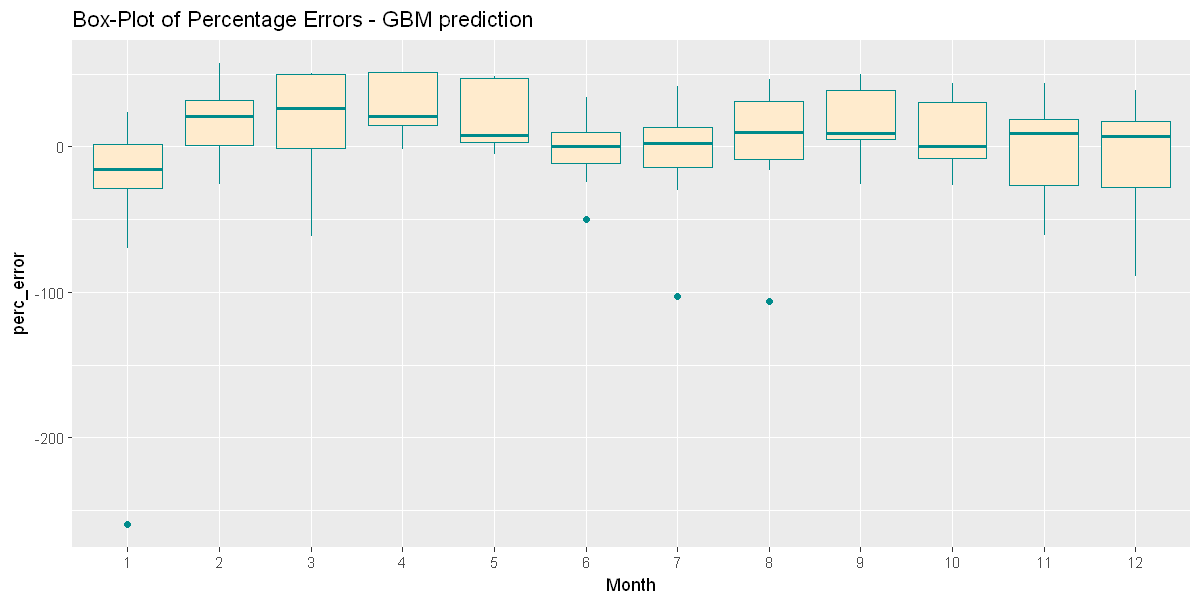

In [201]:
ggplot(rtp, aes(x = Month, y = perc_error)) + geom_boxplot(colour = "darkcyan", fill = "blanchedalmond") + ggtitle("Box-Plot of Percentage Errors - GBM prediction")

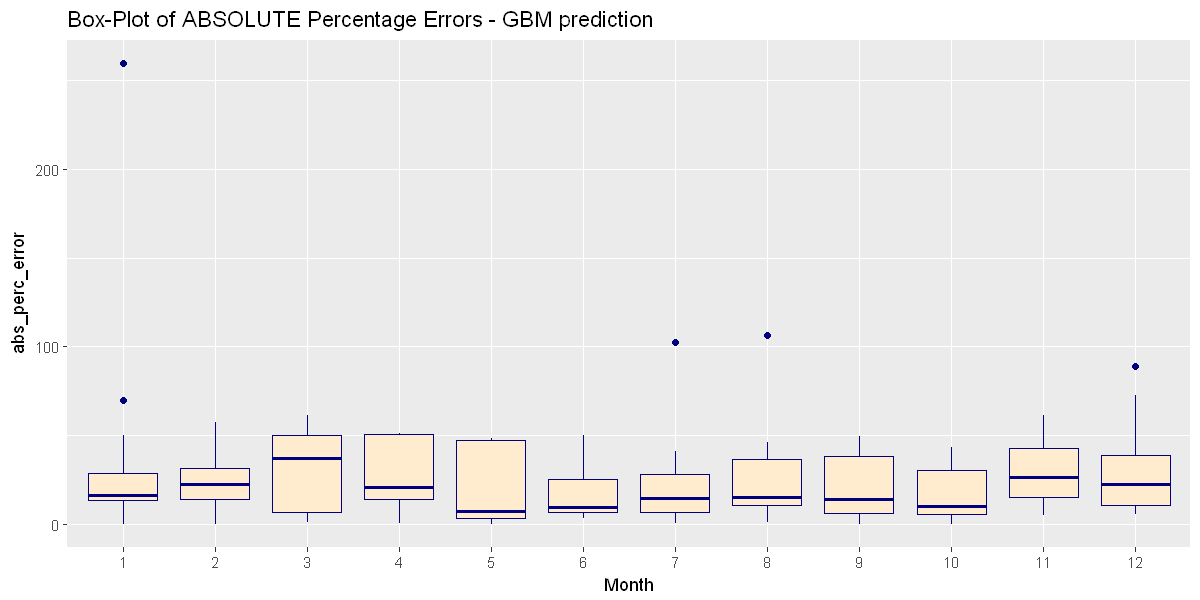

In [202]:
ggplot(rtp, aes(x = Month, y = abs_perc_error)) + geom_boxplot(colour = "navy", fill = "blanchedalmond") + ggtitle("Box-Plot of ABSOLUTE Percentage Errors - GBM prediction")

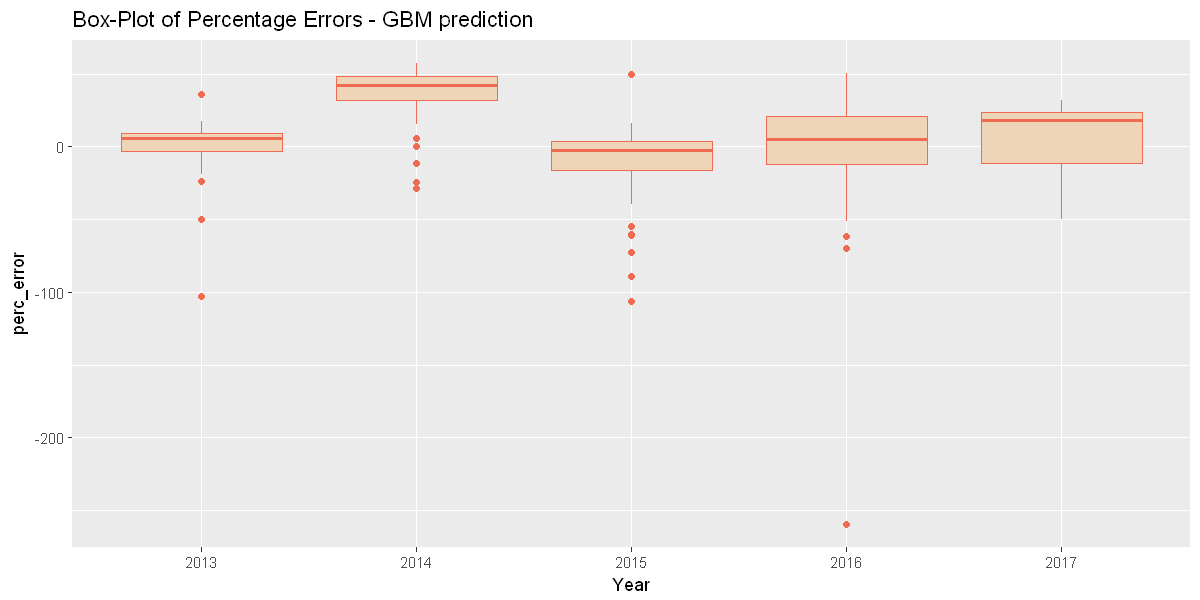

In [203]:
ggplot(rtp, aes(x = Year, y = perc_error)) + geom_boxplot(colour = "coral2", fill = "bisque2") + ggtitle("Box-Plot of Percentage Errors - GBM prediction")

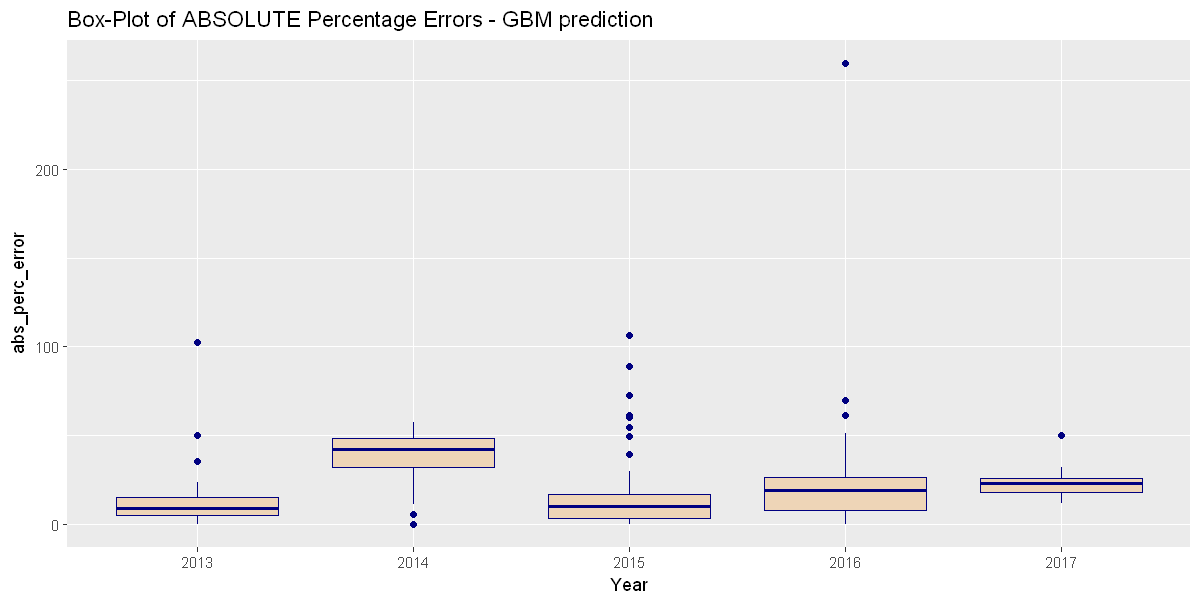

In [204]:
ggplot(rtp, aes(x = Year, y = abs_perc_error)) + geom_boxplot(colour = "navy", fill = "bisque2") + ggtitle("Box-Plot of ABSOLUTE Percentage Errors - GBM prediction")

### Forecasting using LASSO

In [205]:
# to make results replicable
set.seed(123)
# load libraries
instala_pacote("glmnet")
library(glmnet) # to fit a LASSO model

In [206]:
# define response variable and predictor variables
response_column <- 4 # Spot Price (medium load) is the 4th column in the dataframe
train_X <- data.matrix(dst_train_small[, -response_column])
train_y <- dst_train_small$Price_Medium

# use cv.glmnet with 10-fold cross-validation to pick lambda
lasso1 <- cv.glmnet(x = train_X, 
                    y = train_y, 
                    alpha = 1, 
                    nfolds = 10, 
                    family = "gaussian", 
                    type.measure = "mse")

In [207]:
summary(lasso1)

           Length Class  Mode     
lambda     86     -none- numeric  
cvm        86     -none- numeric  
cvsd       86     -none- numeric  
cvup       86     -none- numeric  
cvlo       86     -none- numeric  
nzero      86     -none- numeric  
name        1     -none- character
glmnet.fit 12     elnet  list     
lambda.min  1     -none- numeric  
lambda.1se  1     -none- numeric  

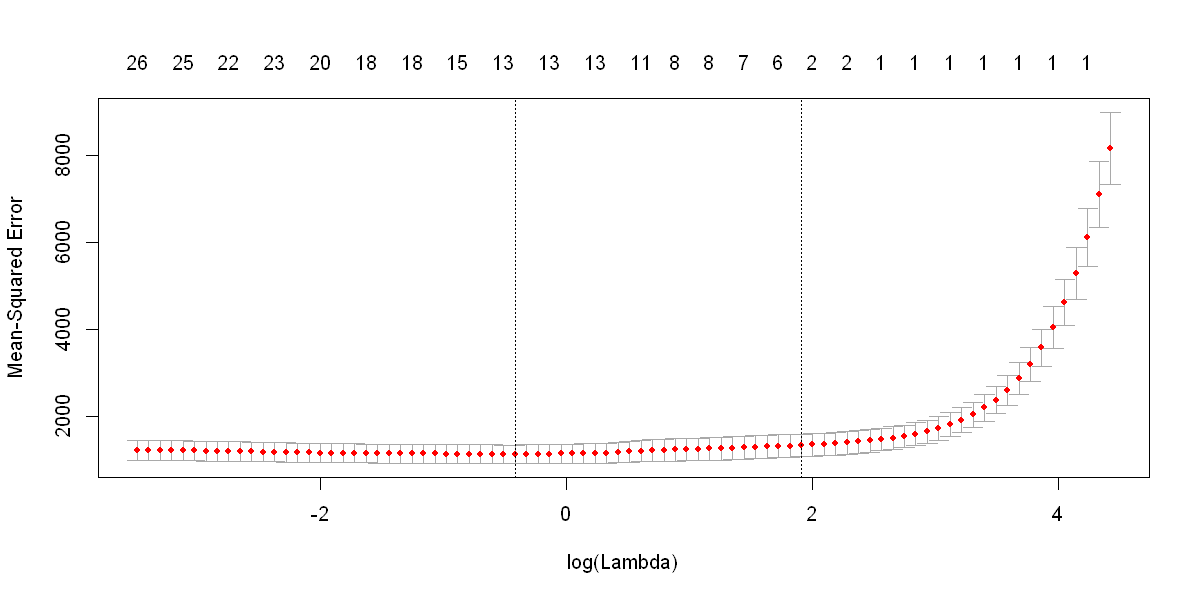

In [208]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot(lasso1)

In the plot above:
The red dotted line shows the cross-validation error and the error bars show the uppper and lower standard deviation.
The dotted vertical line to the left is for the optimal lambda that gives minimum mean cross-validation error.
The vertical line to the right is for the lambda where cross-validation error falls within one standard error of the minimum error.

The number of nonzero coefficients for different lambda is shown along the axis at the top. The values for lambda and associated coefficients are printed below.

### Lambda that gives minimum mean cross-validated error:

In [209]:
round(lasso1$lambda.min, 4)

[1] 0.6605

### Largest lambda with mean cross-validated error within 1 standard error of the minimum error:

In [210]:
round(lasso1$lambda.1se, 4)

[1] 6.7605

### Coefficients based on lambda that gives minimum mean cross-validated error:

In [211]:
coefs_lasso = as.matrix(coef(lasso1, s = "lambda.min"))

In [212]:
# Create dataframe (df_coefs_lasso) with "nice" row and column names
# Creates data frame with ALL lasso coefficients (including = 0)
names = rownames(coefs_lasso)

rownames(coefs_lasso) <- NULL
df_coefs_lasso <- cbind(names,coefs_lasso)
colnames(df_coefs_lasso) = c("Variable", "Coefficient")

# Convert to dataframe
df_coefs_lasso = as.data.frame(df_coefs_lasso)   

In [213]:
head(df_coefs_lasso)

Variable,Coefficient
(Intercept),73.0365242768332
Year,2.91616426555802
Month,-2.32372608617624
Wk_of_Month,-0.808941246663143
Price_Medium_lag_1,0.826789438903539
Price_Medium_lag_2,0.0766494379631563


In [214]:
tail(df_coefs_lasso)   

,Variable,Coefficient
22,ENA_Average_MW_lag_3,-0.000309553948903491
23,ENA_Average_MW_lag_4,0
24,ENA_Average_MW_lag_5,0.0002057639995938
25,ENA_Average_MW_lag_6,0
26,ENA_Average_MW_lag_7,0
27,ENA_Average_MW_lag_8,0


In [215]:
# Create dataframe with only variables whose coefficients are different from zero
df_coefs_lasso_gt_0 = subset(df_coefs_lasso, Coefficient !=0)

In [219]:
head(df_coefs_lasso_gt_0, 20)

,Variable,Coefficient
1,(Intercept),73.0365242768332
2,Year,2.91616426555802
3,Month,-2.32372608617624
4,Wk_of_Month,-0.808941246663143
5,Price_Medium_lag_1,0.826789438903539
6,Price_Medium_lag_2,0.0766494379631563
7,Price_Medium_lag_3,-0.173129397549443
10,Price_Medium_lag_6,0.118373387521365
12,SE_EAR_Average_MW_lag_1,-0.000125917976740713
13,SE_EAR_Average_MW_lag_2,-0.000222788190820093


### Varying lambda

While the model selected by cv.glmnet() can be used for making predictions, we also want to better understand how the values of lambda impact the estimated coefficients. 

Such information can be produced by the glmnet() function.

In the plot that's generated below, it can be observed that by increasing the value of lambda, the regression parameters are increasingly penalised, and thus move closer to zero.

In the lambda plot below, you can see how the coefficients gradually decrease in value as lambda increaes. 


This shows the value of LASSO regression: the algorithm deals very well with problematic predictors, for example situations where the predictors are higly correlated with one another (multi-collinearity).


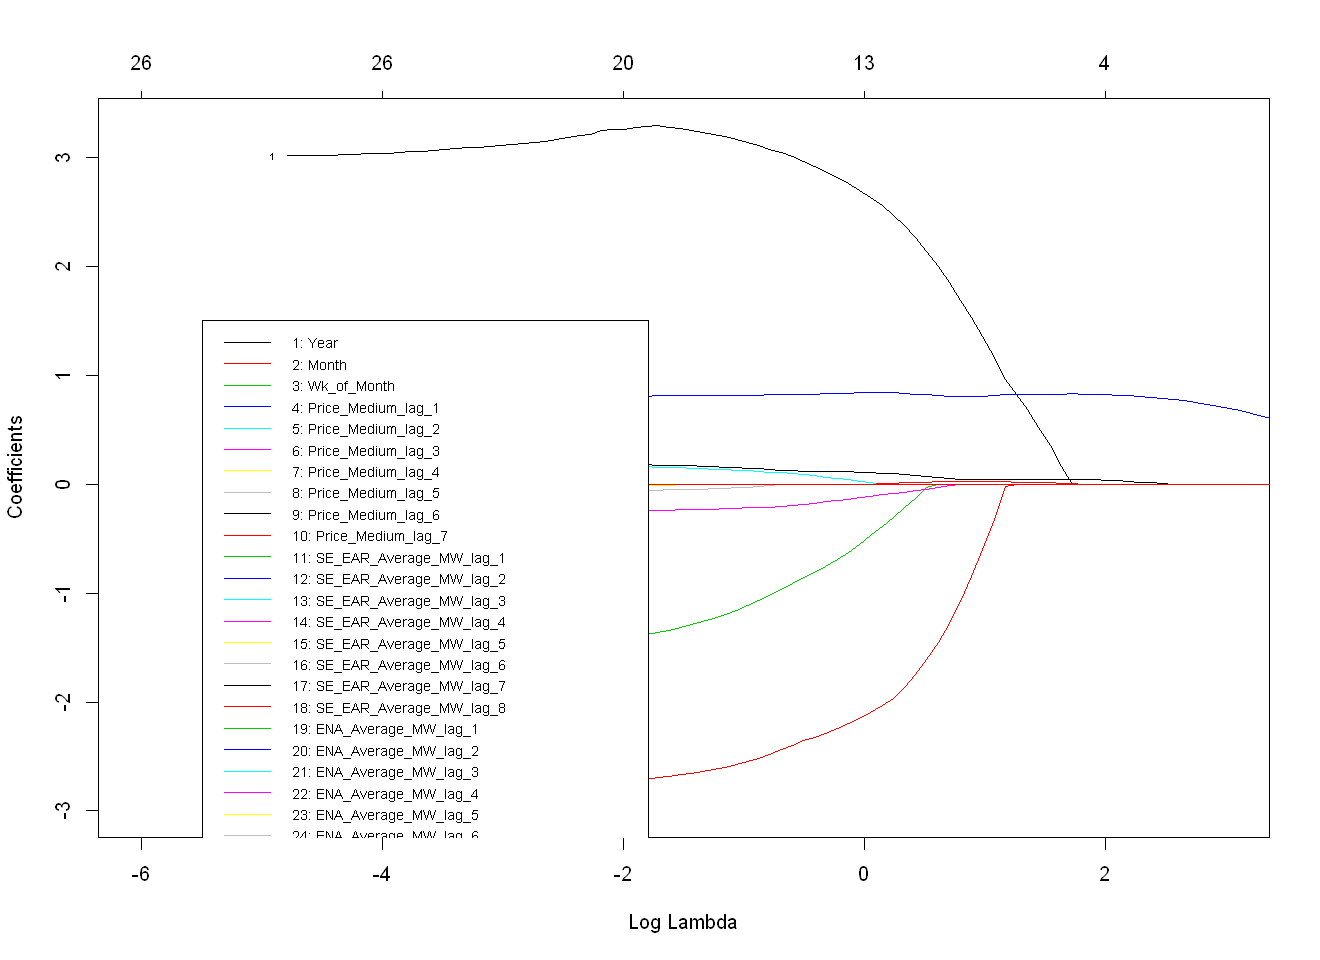

In [220]:
lasso2 <- glmnet(x = train_X, 
                 y = train_y, 
                 alpha = 1, 
                 family = "gaussian")

# identify variable names
vn = colnames(train_X)
vid <- as.character(seq(1, length(vn)))

# check and exclude the variables with coefficient value 0 
vnat = coef(lasso2)   # Sparse matrix with lasso coeffs and values
vnat_f <- vnat[-1, ncol(vnat)] # Delete intercept
vid <- vid[vnat_f != 0] # Select indexes of nonzero coefficients
vn <- vn[vnat_f != 0]   # Select only variables with coefficients different from zero

# define the legend description, line type, and line color
nvars <- length(vn)
legend_desc <- paste(vid, vn, sep=": ")
mylty <- rep(1,nvars)
mycl <- seq(1,nvars)

# plot
options(repr.plot.width = 11, repr.plot.height = 8)
plot(lasso2, xvar = "lambda", label = TRUE, col = mycl, xlim = c(-6, 3))
legend(-5.5, 1.5, legend_desc, lty = mylty, col = mycl, cex = 0.7) 

In [222]:
#  Forecasting with lasso (and lambda.min)
newdata <- data.matrix(dst_test_small[, -response_column])  # eliminates response column from dataframe "newdata"
pred_lasso <- predict(lasso1, newx = newdata, s = "lambda.min")

In [224]:
# This entire cell fixes indexing and column/row name problems

actual = as.matrix(dst_test_small$Price_Medium)
row.names(actual) <- 1:nrow(actual)

row.names(pred_lasso) <- 1:nrow(pred_lasso)
colnames(pred_lasso) = NULL

perc_error_lasso = round(100*((actual-pred_lasso)/actual), digits = 3) # percentage errors
abs_perc_error_lasso = abs(perc_error_lasso)  # ABSOLUTE percentage errors
row.names(perc_error_lasso) <- 1:nrow(perc_error_lasso)
colnames(perc_error_lasso) = NULL

In [225]:
# Creates data frame with lasso forecasts and errors
result_test_period_lasso = data.frame(actual, forecast = pred_lasso, perc_error_lasso, abs_perc_error_lasso)

In [226]:
# Summary of forecasts and errors
summary(result_test_period_lasso)

     actual          forecast      perc_error_lasso   abs_perc_error_lasso
 Min.   : 30.25   Min.   : 48.26   Min.   :-273.879   Min.   :  0.122     
 1st Qu.:131.09   1st Qu.:168.29   1st Qu.: -27.934   1st Qu.:  6.321     
 Median :254.33   Median :253.82   Median :  -3.402   Median : 12.898     
 Mean   :331.40   Mean   :333.11   Mean   : -18.199   Mean   : 26.577     
 3rd Qu.:388.48   3rd Qu.:423.60   3rd Qu.:   7.571   3rd Qu.: 30.997     
 Max.   :822.83   Max.   :774.27   Max.   :  43.561   Max.   :273.879     

In [227]:
# Creates data frame with lasso forecasts, errors and date information
rtp_lasso = cbind(result_test_period_lasso,dst_test[,c(1,2,3,8,9,10)])  # Contains results and date/time information - will be useful in plotting

In [228]:
head(rtp_lasso)

actual,forecast,perc_error_lasso,abs_perc_error_lasso,Start.Date,End.Date,Date,Year,Month,Wk_of_Month
356.80,334.0123,6.387,6.387,18/05/2013,24/05/2013,24/05/2013,2013,5,4
357.29,317.8061,11.051,11.051,25/05/2013,31/05/2013,31/05/2013,2013,5,5
324.69,311.6086,4.029,4.029,01/06/2013,07/06/2013,07/06/2013,2013,6,1
180.95,297.0899,-64.183,64.183,08/06/2013,14/06/2013,14/06/2013,2013,6,2
193.93,178.9803,7.709,7.709,15/06/2013,21/06/2013,21/06/2013,2013,6,3
167.90,184.1652,-9.687,9.687,22/06/2013,28/06/2013,28/06/2013,2013,6,4


In [231]:
# Finding the rows with ABSOLUTE % errors above 30%
subset(rtp_lasso, abs_perc_error_lasso > 30)

,actual,forecast,perc_error_lasso,abs_perc_error_lasso,Start.Date,End.Date,Date,Year,Month,Wk_of_Month
4,180.95,297.08992,-64.183,64.183,08/06/2013,14/06/2013,14/06/2013,2013,6,2
7,98.56,190.09815,-92.876,92.876,29/06/2013,05/07/2013,05/07/2013,2013,7,1
16,259.04,172.91896,33.246,33.246,31/08/2013,06/09/2013,06/09/2013,2013,9,1
38,822.83,464.39580,43.561,43.561,01/02/2014,07/02/2014,07/02/2014,2014,2,1
56,333.80,564.79562,-69.202,69.202,07/06/2014,13/06/2014,13/06/2014,2014,6,2
59,398.95,540.12151,-35.386,35.386,28/06/2014,04/07/2014,04/07/2014,2014,7,1
64,815.92,537.76502,34.091,34.091,02/08/2014,08/08/2014,08/08/2014,2014,8,2
81,549.18,757.91550,-38.009,38.009,29/11/2014,05/12/2014,05/12/2014,2014,12,1
85,388.48,651.47678,-67.699,67.699,27/12/2014,02/01/2015,02/01/2015,2015,1,1
114,236.51,332.79014,-40.709,40.709,11/07/2015,17/07/2015,17/07/2015,2015,7,3


In [230]:
# Finding the number of rows with absolute % errors above 10%, 20%, 30%

print(paste0(" LASSO - Number of forecasts with abs. error > 10%: ",nrow(subset(rtp_lasso, abs_perc_error > 10))))
print(paste0(" LASSO - Number of forecasts with abs. error > 20%: ",nrow(subset(rtp_lasso, abs_perc_error > 20))))
print(paste0(" LASSO - Number of forecasts with abs. error > 30%: ",nrow(subset(rtp_lasso, abs_perc_error > 30))))

[1] " LASSO - Number of forecasts with abs. error > 10%: 137"
[1] " LASSO - Number of forecasts with abs. error > 20%: 93"
[1] " LASSO - Number of forecasts with abs. error > 30%: 67"


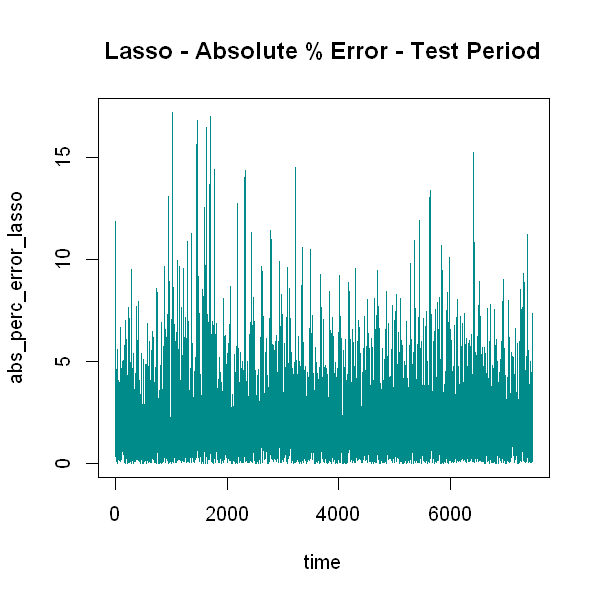

In [289]:
time=1:nrow(result_test_period_lasso)
plot(time,abs_perc_error_lasso, type ="l", col = "darkcyan", main = "Lasso - Absolute % Error - Test Period")

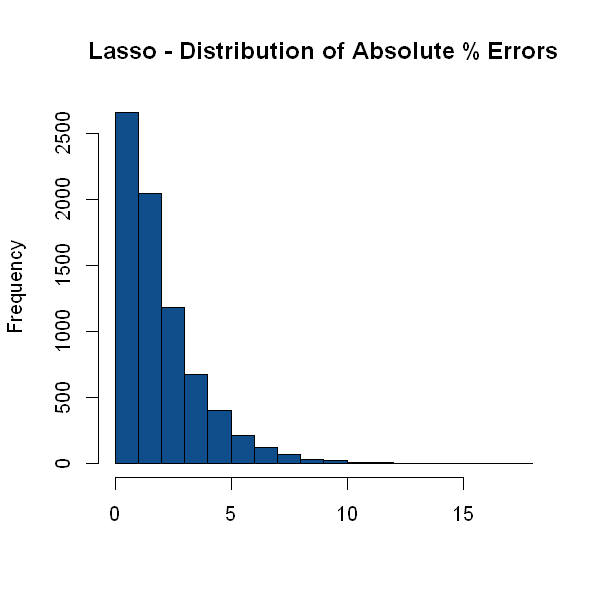

In [291]:
# Histogram of Absolute Percentage Errors 
options(repr.plot.width = 5, repr.plot.height = 5)
hist(abs_perc_error_lasso, main = "Lasso - Distribution of Absolute % Errors", col = "dodgerblue4", xlab = NULL)

In [294]:
MAPE_lasso = mean(abs_perc_error_lasso)
print(paste0("MAPE Lasso= ", round(MAPE_lasso,4)))

[1] "MAPE Lasso= 1.9726"


In [298]:
print(paste0("LASSO - Minimum Absolute % Error (test period): ", min(abs_perc_error_lasso, na.rm = TRUE)))

[1] "LASSO - Minimum Absolute % Error (test period): 0"


In [299]:
print(paste0("LASSO - Maximum Absolute % Error (test period): ", max(abs_perc_error_lasso, na.rm = TRUE)))

[1] "LASSO - Maximum Absolute % Error (test period): 17.223"


`geom_smooth()` using method = 'gam'


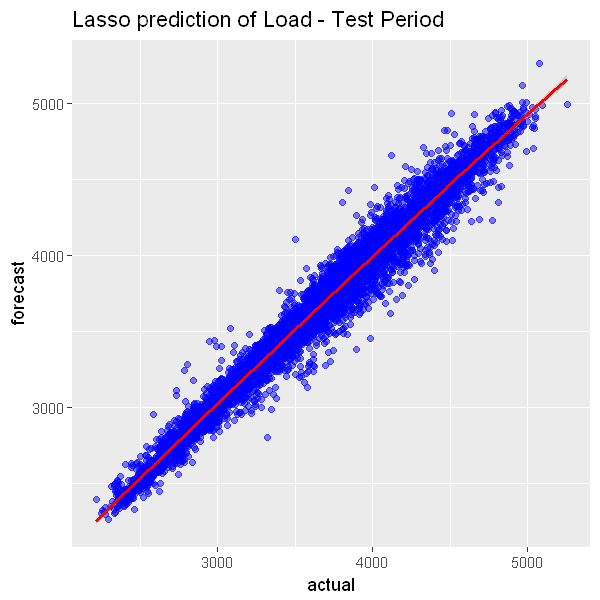

In [300]:
library(ggplot2)

options(repr.plot.width = 5, repr.plot.height = 5)
ggplot(rtp_lasso, aes(x = actual, y = forecast)) + 
    geom_point(colour = "blue", alpha = 0.5) +
    stat_smooth(colour = "red") + 
    ggtitle("Lasso prediction of Load - Test Period")

png 
  2

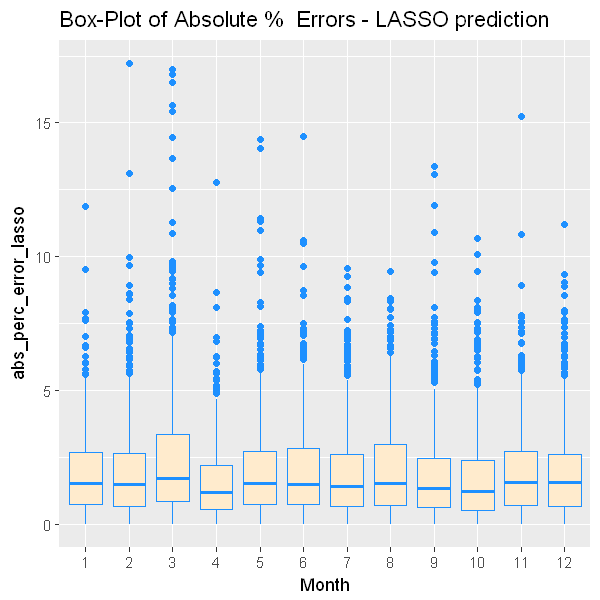

In [301]:
pdf("box_plot_lasso_months.pdf")
ggplot(rtp_lasso, aes(x = Month, y = abs_perc_error_lasso)) + geom_boxplot(colour = "dodgerblue", fill = "blanchedalmond") + ggtitle("Box-Plot of Absolute % Errors - LASSO prediction")
dev.off()
# To show graph on screen
ggplot(rtp_lasso, aes(x = Month, y = abs_perc_error_lasso)) + geom_boxplot(colour = "dodgerblue", fill = "blanchedalmond") + ggtitle("Box-Plot of Absolute %  Errors - LASSO prediction")

png 
  2

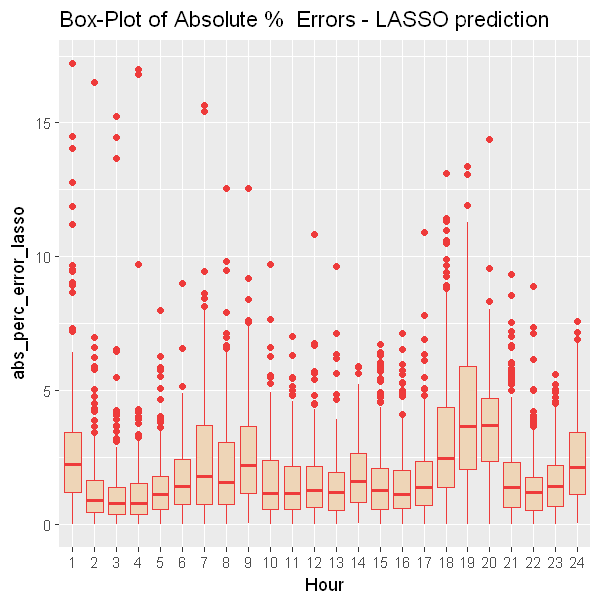

In [302]:
# To create graph in pdf format 
pdf("box_plot_lasso_hours.pdf")
ggplot(rtp_lasso, aes(x = Hour, y = abs_perc_error_lasso)) + geom_boxplot(colour = "brown2", fill = "bisque2") + ggtitle("Box-Plot of Absolute %  Errors - LASSO prediction")
dev.off()
# To show graph on screen
ggplot(rtp_lasso, aes(x = Hour, y = abs_perc_error_lasso)) + geom_boxplot(colour = "brown2", fill = "bisque2") + ggtitle("Box-Plot of Absolute %  Errors - LASSO prediction")

png 
  2

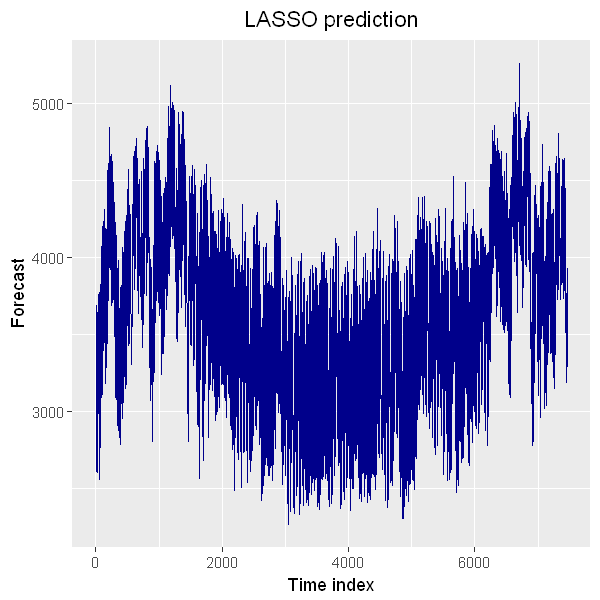

In [309]:
# LASSO Forecasts - line plot
# Create pdf file with graph
pdf("forec_lasso.pdf")
ggplot(rtp_lasso, aes(x = 1:nrow(rtp_lasso), y = forecast)) + xlab("Time index") + ylab("Forecast") + theme(plot.title = element_text(hjust = 0.5)) + ggtitle("LASSO prediction") + geom_line(colour = "darkblue")
dev.off()
# To show graph on screen
ggplot(rtp_lasso, aes(x = 1:nrow(rtp_lasso), y = forecast)) + 
    xlab("Time index") + ylab("Forecast") + 
    theme(plot.title = element_text(hjust = 0.5)) + 
    ggtitle("LASSO prediction") + geom_line(colour = "darkblue")


png 
  2

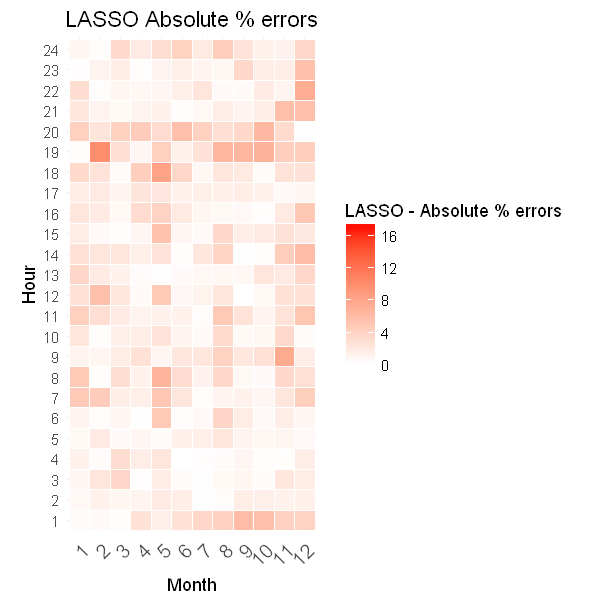

In [312]:
# Heat map - Absolute Percentage Errors - LASSO
# Create pdf file with graph
pdf("heat_map_abs_errors_lasso.pdf")
ggplot(data = rtp_lasso, aes(Month, Hour, fill = abs_perc_error_lasso))+
geom_tile(color = "white")+ scale_fill_gradient2(low = "blue", high = "red", mid = "white",  name="LASSO - Absolute % errors") +
  theme_minimal() + theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 10, hjust = 1)) +  theme(plot.title = element_text(hjust = 0.5)) + ggtitle("LASSO Absolute % errors")+ coord_fixed()
dev.off()
# To show graph on screen
ggplot(data = rtp_lasso, aes(Month, Hour, fill = abs_perc_error_lasso)) + geom_tile(color = "white") +
        scale_fill_gradient2(low = "blue", high = "red", mid = "white",  name="LASSO - Absolute % errors") +
        theme_minimal() + theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 12, hjust = 1)) +  
        theme(plot.title = element_text(hjust = 0.5)) + ggtitle("LASSO Absolute % errors")+ coord_fixed()


png 
  2

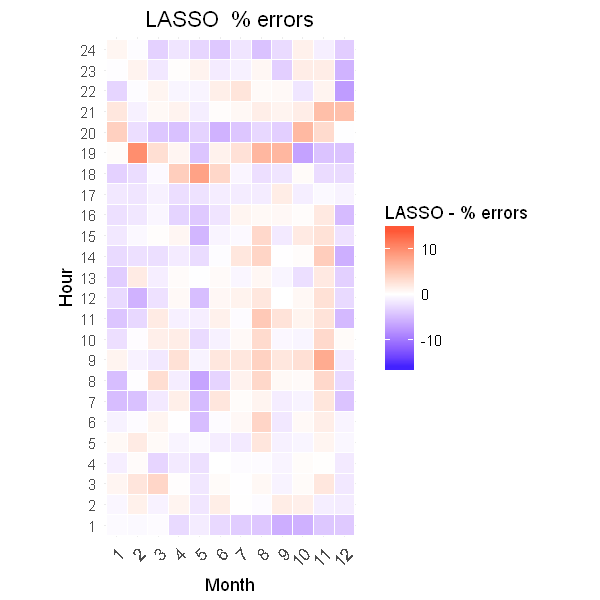

In [313]:
# Heat map - Percentage Errors - LASSO
# Create pdf file with graph
pdf("heat_map_errors_lasso.pdf")
ggplot(data = rtp_lasso, aes(Month, Hour, fill = perc_error_lasso))+
geom_tile(color = "white")+ scale_fill_gradient2(low = "blue", high = "red", mid = "white",  name="LASSO - % errors") +
  theme_minimal() + theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 10, hjust = 1)) +  theme(plot.title = element_text(hjust = 0.5)) + ggtitle("LASSO  % errors")+ coord_fixed()
dev.off()

# To show graph on screen
ggplot(data = rtp_lasso, aes(Month, Hour, fill = perc_error_lasso))+
geom_tile(color = "white")+ scale_fill_gradient2(low = "blue", high = "red", mid = "white",  name="LASSO - % errors") +
  theme_minimal() + theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 10, hjust = 1)) +  theme(plot.title = element_text(hjust = 0.5)) + ggtitle("LASSO  % errors")+ coord_fixed()


### Comparing different methods

In [89]:
instala_pacote("caret")

In [ ]:
library(caret)

In [ ]:
mat = lapply(c("LogitBoost", 'xgbTree', 'rf', 'svmRadial'), 
          function (met) {
  train(subClasTrain~., method=met, data=smallSetTrain)
})